In [1]:
import sys
import random
import numpy as np
import jax
import jax.numpy as jnp

from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

/Users/haru4me/Documents/diffusion-models-learning/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preproc_data(data: np.ndarray) -> np.ndarray:
    data = jnp.array(data)
    data = data.astype(float)
    data /= 255
    return jax.image.resize(data, shape=(data.shape[0], 14, 14), method="bicubic", )

In [3]:
training = MNIST(
    root="../data/",
    train=True,
    download=True,
).data.numpy()

test = MNIST(
    root="../data/",
    train=False,
    download=True,
).data.numpy()

training = preproc_data(training)
test = preproc_data(test)

In [4]:
def sampling_real(data: np.ndarray, batch_size: int = 32, shuffle: bool = True) -> jnp.array:
    indexes = np.arange(data.shape[0]).astype(int)
    if shuffle:
        indexes = np.random.permutation(indexes)
    num_batches = data.shape[0] // batch_size
    batches_indexes = indexes[:num_batches * batch_size].reshape(num_batches, batch_size)
    for batch_indexes in batches_indexes:
        yield jnp.array(data[batch_indexes, :, :])

@jax.jit
def sample_steps(data: jnp.array, max_steps: int = 100, rng = None) -> jnp.array:
    if rng == None:
        seed = random.randrange(sys.maxsize)
        rng = jax.random.PRNGKey(seed)
    batch_size = data.shape[0]
    return jax.random.uniform(rng, minval=0, maxval=max_steps, shape=(batch_size, )).round().astype(int)

@jax.jit
def sample_noise(data: jnp.array, batch_size: int = 32, rng = None) -> jnp.array:
    if rng == None:
        seed = random.randrange(sys.maxsize)
        rng = jax.random.PRNGKey(seed)
    return jax.random.normal(rng, shape=data.shape)

def linear_beta_schedule(max_steps: int = 100):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start, beta_end, max_steps)

@jax.jit
def alphas_cum_prod(betas, steps):
    alphas = 1 - betas
    alphas_cum_prod = alphas.cumprod()
    return alphas_cum_prod[steps]

@jax.jit
def noised_data(data: jnp.array, steps: jnp.array, noise: jnp.array) -> jnp.array:

    betas = linear_beta_schedule()
    alphas = alphas_cum_prod(betas, steps)
    alpha = alphas[:, None, None]

    biase = jnp.multiply(data, jnp.sqrt(alphas)[:, None, None])
    variance = jnp.multiply(noise, jnp.sqrt(1 - alphas)[:, None, None])

    return  biase + variance

def plot_samples(samples: jnp.array, n_cols: int = None, n_rows: int = None):
    rows = []
    if n_cols is not None:
        n_rows = samples.shape[0] // n_cols
    elif n_rows is not None:
        n_cols = samples.shape[0] // n_rows
    else:
        raise ValueError("Choose cols or rows")
    for i in range(n_rows):
        start = n_cols * i
        end = n_cols * (i + 1)
        rows.append(jnp.hstack(samples[start:end]))
    grid = jnp.vstack(rows)
    plt.imshow(grid, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

In [5]:
sample_real_train = next(sampling_real(training))
steps = sample_steps(sample_real_train)
noise = sample_noise(sample_real_train)
sample_fake_train = noised_data(sample_real_train, steps, noise)

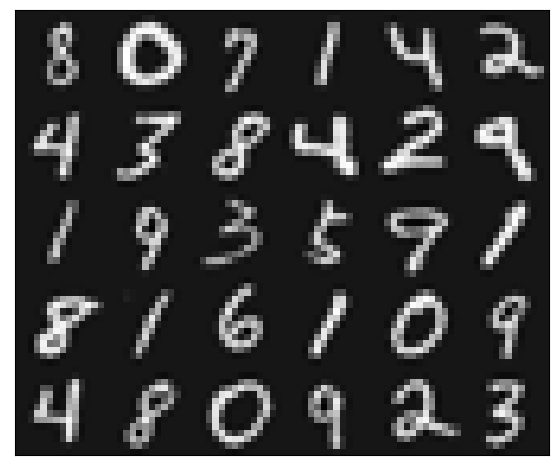

In [6]:
plot_samples(sample_real_train, n_rows=5)

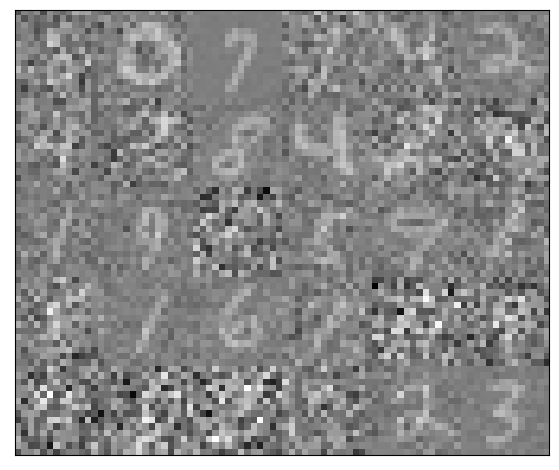

In [7]:
plot_samples(sample_fake_train, n_rows=5)

In [8]:
import flax.linen as nn

In [9]:
class DDPM(nn.Module):

    @nn.compact
    def __call__(self, x, t):

        img_size = x.shape[1:]
        batch_size = list(x.shape)[0]
        x = x.reshape(x.shape[0], -1)
        t = t.reshape(t.shape[0], -1)
        z = jnp.hstack((x, t))

        z = nn.Dense(256)(z)
        z = nn.relu(z)
        z = nn.Dense(512)(z)
        z = nn.relu(z)
        z = nn.Dense(256)(z)
        z = nn.relu(z)
        z = nn.Dense(jnp.prod(np.prod(img_size)))(z)
        z = z.reshape(batch_size, *img_size)

        return z

In [33]:
from flax.core.frozen_dict import freeze
from typing import Callable

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class StdConv(nn.Conv):

    def __std(self, x, axis, eps=1e-5):
        mean = x.mean(axis, keepdims=True)
        var = x.var(axis, keepdims=True)
        return (x - mean) * jnp.sqrt(var + eps)
    
    def apply(self, params, x):
        params = params.unfreeze()
        params['params']['kernel'] = self.__std(params['params']['kernel'], [0, 1, 2])
        params = freeze(params)
        return super().apply(params, x)

class SinPosEmbs(nn.Module):
    dim : int

    @nn.compact
    def __call__(self, x):
        half_dim = self.dim // 2
        embeddings = jnp.log(10000) / (half_dim - 1)
        embeddings = jnp.exp(- jnp.arange(half_dim) * embeddings)
        embeddings = x[:, None] * embeddings[None, :]
        embeddings = jnp.concatenate((jnp.sin(embeddings), jnp.cos(embeddings)), axis=-1)
        return embeddings

class NetBlock(nn.Module):
    dim: int
    groups: int = 8

    def setup(self):
        self.proj = StdConv(self.dim, (3, 3), padding=1)
        self.norm = nn.GroupNorm(num_groups=self.groups)
        self.act = nn.activation.silu

    def __call__(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)
        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift
        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    dim: int
    time_emb_dim: tuple = None
    groups: int = 8

    def setup(self):
        self.mlp = nn.Sequential([nn.activation.silu, nn.Dense(self.dim * 2)]) if self.time_emb_dim is not None else None
        self.block1 = NetBlock(self.dim, groups=self.groups)
        self.block2 = NetBlock(self.dim, groups=self.groups)
        self.res_conv = nn.Conv(self.dim, (1, 1))
    
    def __call__(self, x, time_emb=None):
        scale_shift = None
        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            time_emb = time_emb[:, None, :, :]
            scale_shift = jnp.array_split(time_emb, 2, axis=-1)
        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)

class PreNorm(nn.Module):
    dim: int
    fn: Callable

    @nn.compact
    def __call__(self, x):
        x = nn.GroupNorm(num_groups=self.dim)(x)
        return self.fn(x)

class LinearAttention(nn.Module):
    dim: int
    heads: int = 4
    dim_head: int = 32

    def setup(self):
        self.scale = self.dim_head ** -0.5
        hidden_dim = self.dim_head * self.heads
        self.to_qkv = nn.Conv(hidden_dim * 3, (1, 1), use_bias=False)
        self.to_out = nn.Sequential([nn.Conv(self.dim, (1, 1)), nn.GroupNorm(num_groups=1)])
    
    def __call__(self, x):
        b, c, h, w = x.shape
        qkv = jnp.array_split(self.to_qkv(x), 3, axis=-1)
        q, k, v = qkv
        q = nn.activation.softmax(q, axis=-2)
        k = nn.activation.softmax(k, axis=-1)
        q *= self.scale
        context = jnp.einsum("b d n h, b e n h -> b d e h", k, v)
        out = jnp.einsum("b d e h, b d n h -> b e n h", context, q)
        return self.to_out(out)


In [50]:
class Unet(nn.Module):
    dims = (32, 64)
    time_dim = 4
    channels = 1
    self_condition = False
    resnet_block_groups = 4

    def setup(self):
        input_channels = self.channels * (2 if self.self_condition else 1)
        self.init_conv = nn.Conv(input_channels, (1, 1))
        dim_in, out_dim = self.dims

        time_dim = self.time_dim * 4
        self.time_mlp = nn.Sequential([
            SinPosEmbs(self.time_dim),
            nn.Dense(time_dim),
            nn.activation.gelu,
            nn.Dense(time_dim),
        ])
        self.block1 = nn.Sequential([
            ResnetBlock(dim_in, time_emb_dim=time_dim), 
            ResnetBlock(dim_in, time_emb_dim=time_dim),
            ResnetBlock(dim_in, time_emb_dim=time_dim)
        ])
        self.attn1 = PreNorm(dim_in, LinearAttention(dim_in))
        self.block2 = nn.Sequential([
            ResnetBlock(out_dim, time_emb_dim=time_dim), 
            ResnetBlock(out_dim, time_emb_dim=time_dim), 
            ResnetBlock(out_dim, time_emb_dim=time_dim)
        ])
        self.attn2 = PreNorm(out_dim, LinearAttention(out_dim))
        self.final = nn.Conv(input_channels, (1, 1))
    
    def __call__(self, x, time):
        x = self.init_conv(x)
        time = self.time_mlp(time)
        x = self.block1(x, time)
        x = self.attn1(x)
        x = self.block2(x, time)
        x = self.attn2(x)
        x = self.final(x)
        return x


In [62]:
model = Unet()
rng = jax.random.PRNGKey(0)
params = model.init(rng, jnp.ones([10,14, 14, 1]), jnp.ones([10, 1]))['params']
outp = model.apply({'params': params}, jnp.ones([10, 14, 14, 1]), jnp.ones([10, 1]))

In [52]:
from functools import partial
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [72]:
@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
  metrics: Metrics

def create_train_state(module, rng, learning_rate):
    params = module.init(rng, jnp.ones([1, 14, 14, 1]), jnp.ones([1, 1]))['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(apply_fn=module.apply, params=params, tx=tx, metrics=Metrics.empty())

# @partial(jax.jit, static_argnums=(0,))
def train_step(state, sample, steps, noise):
    def loss_fn(params):
        predicted_noise = state.apply_fn({'params': params}, noised_sample, steps)
        loss = optax.l2_loss(predictions=predicted_noise, targets=noise).mean()
        return loss
    noised_sample = noised_data(sample, steps, noise)
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

# @jax.jit
def validate(state, sample, steps, noise):
    noised_sample = noised_data(sample, steps, noise)
    predicted_noise = state.apply_fn({'params': params}, noised_sample, steps)
    loss = optax.l2_loss(predictions=predicted_noise, targets=noise).mean()
    metric_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state


def sampling(state, noised_sample, max_steps: int = 100):
    steps = jnp.arange(1, max_steps+1).astype('int32').reshape(-1, 1)
    steps = jnp.repeat(steps, noised_sample.shape[0], axis=1)
    betas = linear_beta_schedule(max_steps)
    alphas = 1 - betas
    alphas_overline = alphas_cum_prod(betas, steps[:, 0])

    C1 = 1 / jnp.sqrt(alphas)
    C2 = (1 - alphas) / jnp.sqrt(1 - alphas_overline)
    for i, t in enumerate(steps):
        if i > 0:
            z = sample_noise(noised_sample) 
        else:
            z = jnp.zeros_like(noised_sample)
        predicted_noise = state.apply_fn({'params': params}, noised_sample, t)
        noised_sample = C1[i] * (noised_sample - C2[i] * predicted_noise) + z * betas[i]
    
    return noised_sample

In [77]:
def experiment(model: nn.Module, data: jnp.array, num_epoches: int = 5, batch_size: int = 64, max_steps: int = 1000, lr: float = 1e-3):
    rng = jax.random.PRNGKey(0)
    state = create_train_state(model, rng, lr)
    loss_history = []

    for epoch in range(num_epoches):

        for real_data in sampling_real(data, batch_size):

            steps = sample_steps(real_data, max_steps, rng)[:, None]
            noise = sample_noise(real_data, max_steps, rng)[:, :, :, None]
            real_data = real_data[:, :, :, None]
            loss_history.append(float(state.metrics.compute().get('loss')))
            state = train_step(state, real_data, steps, noise)
            state = validate(state, real_data, steps, noise)
        loss_history.append(float(state.metrics.compute().get('loss')))
        print(f"Loss: %.4f" % loss_history[-1])

    val_noise = sample_noise(real_data, max_steps, rng)[:20]
    generated = sampling(state, val_noise, max_steps)

    return state, loss_history, generated

In [ ]:
model = Unet()
state, loss, samples = experiment(model, training)

In [9]:
plot_samples(samples, n_cols=5)

NameError: name 'plot_samples' is not defined

In [12]:
jnp.array(1).reshape(-1, 1).shape

(1, 1)

In [14]:
(jnp.ones((20, 1)) * 10).shape

(20, 1)